# 한국 부동산 시장 분석 및 투자 전략 수립

## 과제 1: 서울 인기구 vs 비인기구 부동산 시장 비교 분석
가격 변동 패턴 비교분석, 지역별 시장 특성 및 투자 매력도 평가

- 인기구: 거래액/거래량 기준 상위 3개구, 비인기구: 거래액/거래량 기준 하위 3개구

- 지역별 시장 특성 시각화
  - 거래 밀도, 평균 거래가, 변동성 지표 등등

- 투자 매력도 -> 변동성, 수익률 
  - 변동성: 월 수익률의 표준편차로 확인
  - 추세지표: 월별 가격의 이동평균 및 이동표준편차

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약일'] = pd.to_datetime(df_sales['계약일'], format='%Y%m%d')
df_sales['계약월'] = pd.to_datetime(df_sales['계약월'], format='%Y-%m-%d')

df_sales_copy = df_sales.copy()
# display(df_sales_copy.info())

In [3]:
# 인기구/비인기구 정의 - 최근 12개월 기준 누적 거래액 기준 상위 3개구 / 하위 3개구

today = pd.to_datetime('2025-07-01')
date_ref = today - pd.DateOffset(years=1)
filtered_year_df = df_sales_copy[(df_sales_copy['계약일'] > date_ref) & (df_sales_copy['계약일'] <= today)]

district_sales_stats = filtered_year_df.groupby('구').agg({
    '거래금액': ['count', 'sum']
}).round(0)

district_sales_stats.columns = ['거래건수', '총거래액']

popular = district_sales_stats.sort_values(by = ['총거래액', '거래건수'], ascending=[False, False]).head(3).index.tolist()
unpopular = district_sales_stats.sort_values(by = ['총거래액', '거래건수'], ascending=[True, False]).head(3).index.tolist()

print(f'인기구: {popular}\n비인기구: {unpopular}')

# 구분 컬럼 추가
df_sales_copy['구분'] = df_sales_copy['구'].apply(
    lambda x: '인기구' if x in popular else ('비인기구' if x in unpopular else '기타')
)

인기구: ['강남구', '송파구', '서초구']
비인기구: ['금천구', '강북구', '종로구']


In [4]:
sales_popular_mask = df_sales_copy['구'].isin(popular + unpopular)
df_popular = df_sales_copy[sales_popular_mask]
# display(df_popular)

## 1. 전체 평균 거래가, 평단가
avg_price_stats = df_popular.groupby('구').agg({
    '거래금액': 'mean',
    '평단가': 'mean'
}).round(0).reset_index()
avg_price_stats.columns = ['구', '평균거래가', '평균평단가']
# display(avg_price_stats)

## 2. 월별/연도별 통계
from da_utils.calc_monthly_annual import calc_monthly_annual

monthly_stats, annual_stats = calc_monthly_annual(df_popular, '구')

monthly_stats['구분'] = monthly_stats['구'].apply(
    lambda x: '인기구' if x in popular else ('비인기구' if x in unpopular else '기타')
)
# display(monthly_stats, annual_stats)

In [11]:
## 3. 거래밀도 (월별 거래건수 / 인구수)

### 구별/월별 인구수 데이터
population_df = pd.read_csv('./data/등록인구(월별).csv', header=[0, 1])
population_df = population_df.drop(columns=[population_df.columns[0]])
population_df.columns = ['_'.join(filter(None, map(str, col))).strip() for col in population_df.columns.values]

population_df_long = population_df.melt(id_vars=['동별(2)_동별(2)'], var_name='계약월_항목', value_name='값')
population_df_long[['계약월','항목']] = population_df_long['계약월_항목'].str.split('_', expand=True)
population_df_long['계약월'] = pd.to_datetime(population_df_long['계약월'].str.replace(" ", "").str.replace(".", "-"), format='%Y-%m')

### Pivot
df_population = population_df_long.pivot_table(
    index=['동별(2)_동별(2)', '계약월'],
    columns='항목',
    values='값'
).reset_index()
df_population.rename(columns={
    '동별(2)_동별(2)': '구',
    '세대 (세대)': '세대수',
    '합계 (명)': '총인구'
}, inplace=True)

population_popular_mask = df_population['구'].isin(popular + unpopular)
population_density = pd.merge(df_population[population_popular_mask], monthly_stats[['구','계약월','월별거래건수']], on=['구', '계약월'], how='left')

### 거래밀도 계산(세대수, 총인구별)
population_density['거래밀도_총인구'] = population_density['월별거래건수'] / population_density['총인구']
population_density['거래밀도_세대수'] = population_density['월별거래건수'] / population_density['세대수']
# display(population_density)

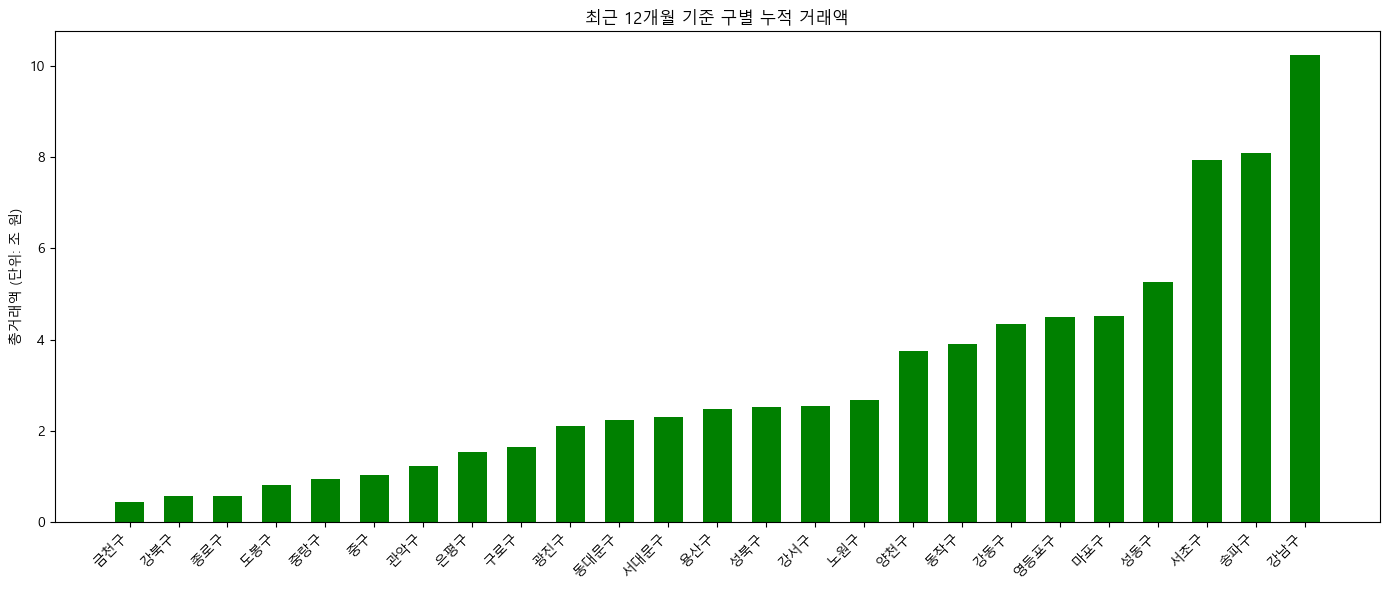

In [6]:
# 인기구/비인기구 구분 그래프
district_sales_stats_plot = district_sales_stats.copy().sort_values('총거래액')
district_sales_stats_plot['총거래액'] = district_sales_stats_plot['총거래액'] / 1e12

x = np.arange(len(district_sales_stats_plot.index))
width = 0.6

fig, ax = plt.subplots(figsize=(14,6))
ax.bar(x, district_sales_stats_plot['총거래액'], width, color='green')
ax.set_xticks(x)
ax.set_xticklabels(district_sales_stats_plot.index, rotation=45, ha='right')
ax.set_ylabel('총거래액 (단위: 조 원)')
ax.set_title('최근 12개월 기준 구별 누적 거래액')
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


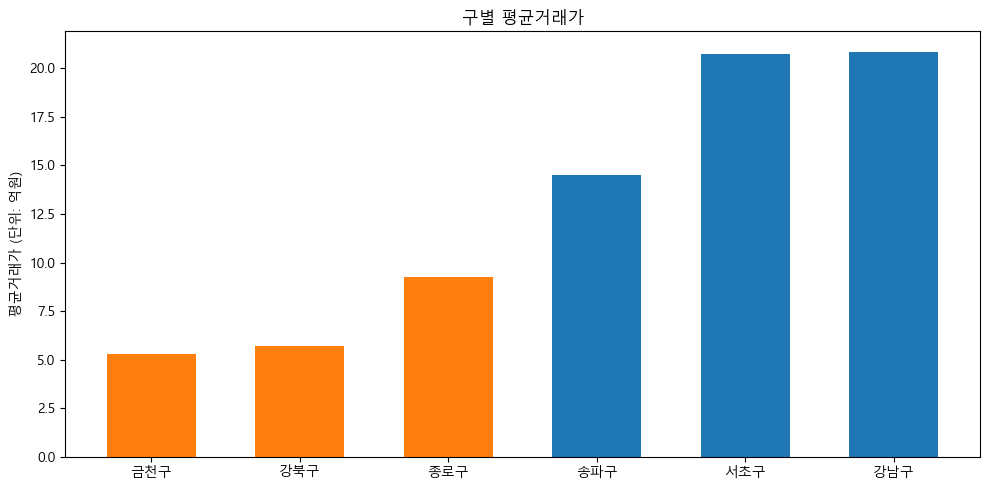

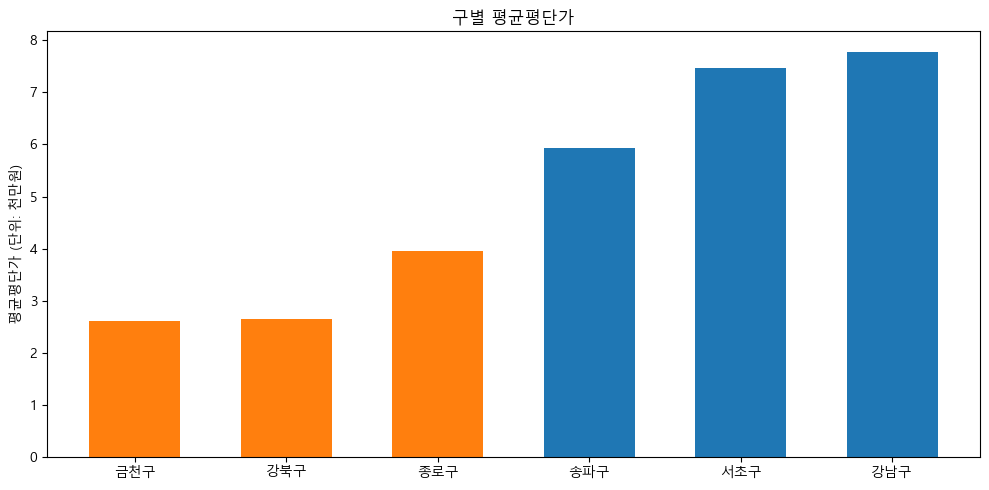

In [30]:
# 핵심 지표의 시각화

## 평균거래가, 평균평단가
colors = ['tab:blue' if g in popular else 'tab:orange' for g in avg_price_stats['구']]

# 값 단위 조정
avg_price_stats_plot = avg_price_stats.copy()
avg_price_stats_plot['평균거래가'] = avg_price_stats_plot['평균거래가'] / 1e8
avg_price_stats_plot['평균평단가'] = avg_price_stats_plot['평균평단가'] / 1e7

x = np.arange(len(avg_price_stats_plot['구']))
width = 0.6

# 평균거래가(억원) 바 차트
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x, avg_price_stats_plot['평균거래가'], width, color=colors)
ax.set_xticks(x)
ax.set_xticklabels(avg_price_stats_plot['구'])
ax.set_ylabel('평균거래가 (단위: 억원)')
ax.set_title('구별 평균거래가')
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

# 평균평단가(천만원) 바 차트
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x, avg_price_stats_plot['평균평단가'], width, color=colors)
ax.set_xticks(x)
ax.set_xticklabels(avg_price_stats_plot['구'])
ax.set_ylabel('평균평단가 (단위: 천만원)')
ax.set_title('구별 평균평단가')
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()



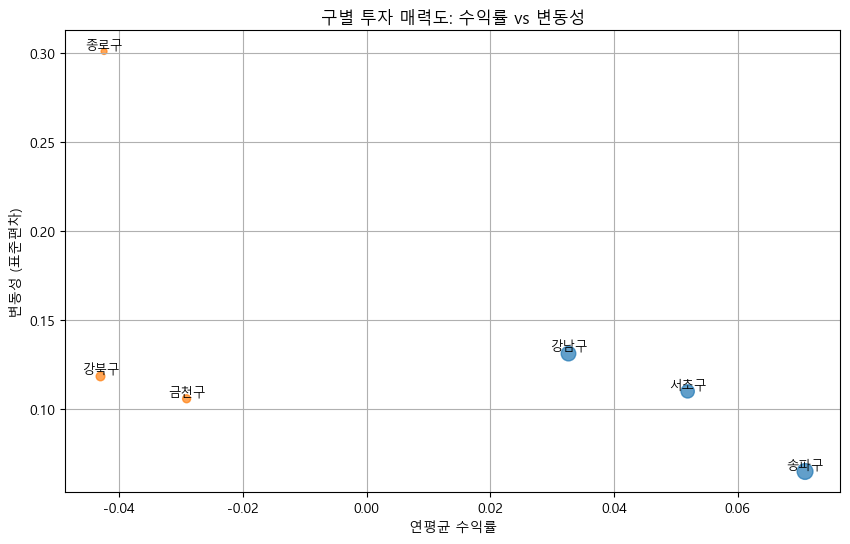

In [31]:
# 구별 연평균 수익률 계산
avg_return = annual_stats.groupby('구')['연간수익률'].mean().reset_index()
avg_annual_stats = annual_stats.groupby('구')['변동성'].mean().reset_index()

# 데이터 병합
investment_df = avg_return.merge(avg_annual_stats, on='구')

# 인기구 / 비인기구
colors = [ 'tab:blue' if x in popular else 'tab:orange' for x in investment_df['구'] ]

# 점 크기: 월별거래건수 평균 (예시)
# monthly_stats에서 구별 평균 거래건수 사용
avg_monthly_volume = monthly_stats.groupby('구')['월별거래건수'].mean().reset_index()
investment_df = investment_df.merge(avg_monthly_volume, on='구')

plt.figure(figsize=(10,6))
plt.scatter(
    investment_df['연간수익률'],
    investment_df['변동성'],
    s=investment_df['월별거래건수']/2,  # 점 크기 조절
    c=colors,
    alpha=0.7
)

for i, row in investment_df.iterrows():
    plt.text(row['연간수익률'], row['변동성'], row['구'], fontsize=9, ha='center', va='bottom')

plt.xlabel('연평균 수익률')
plt.ylabel('변동성 (표준편차)')
plt.title('구별 투자 매력도: 수익률 vs 변동성')
plt.grid(True)
plt.show()

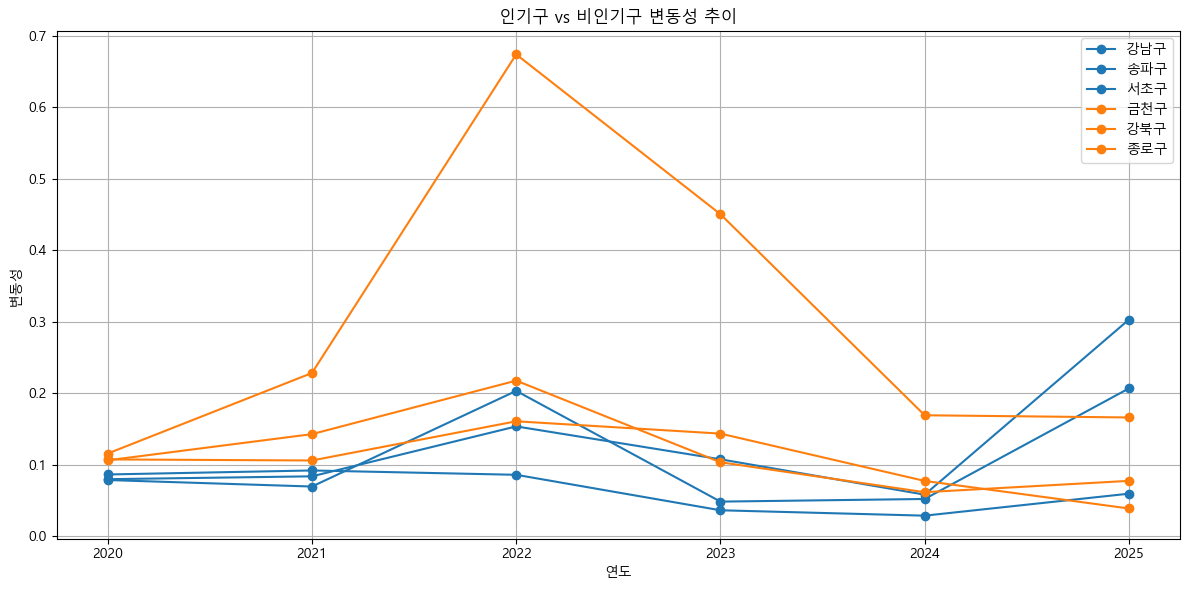

In [32]:
# 변동성 추이

plt.figure(figsize=(12,6))

# 인기구 라인
for g in popular:
    plt.plot(annual_stats[annual_stats['구'] == g]['연도'],
             annual_stats[annual_stats['구'] == g]['변동성'],
             marker='o', label=g, color='tab:blue')

# 비인기구 라인
for g in unpopular:
    plt.plot(annual_stats[annual_stats['구'] == g]['연도'],
             annual_stats[annual_stats['구'] == g]['변동성'],
             marker='o', label=g, color='tab:orange')

plt.title('인기구 vs 비인기구 변동성 추이')
plt.xlabel('연도')
plt.ylabel('변동성')
plt.xticks(annual_stats['연도'].unique())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

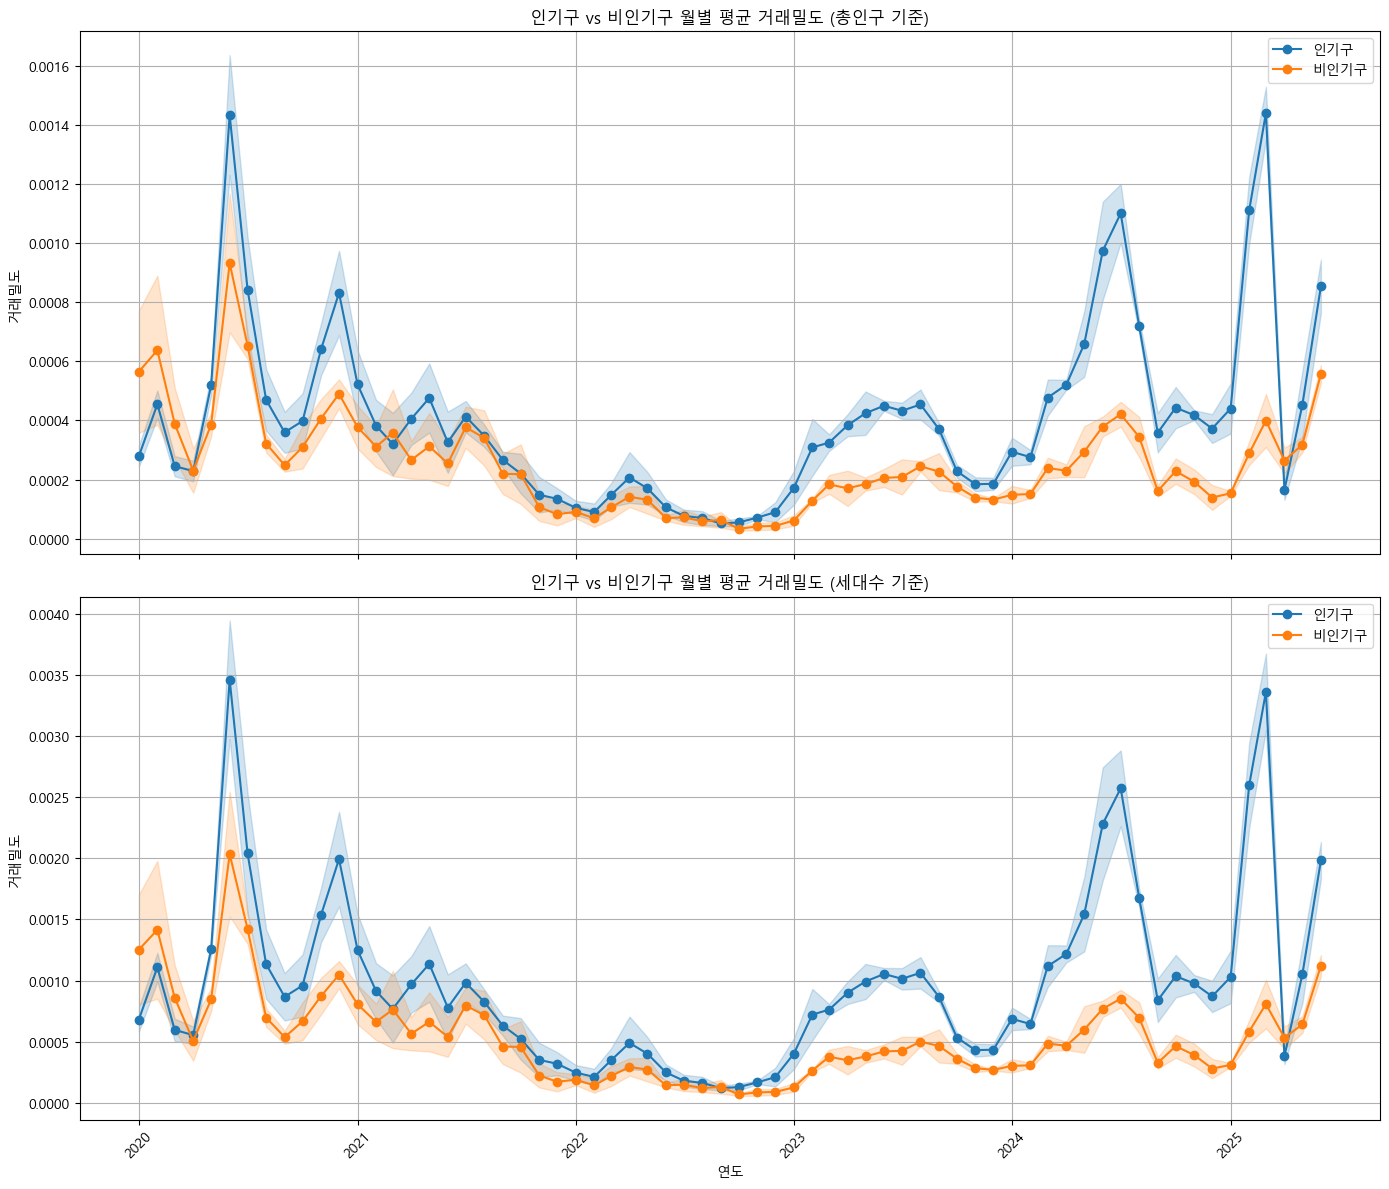

In [33]:
# 월별 거래밀도 비교
df_plot = population_density.copy()
df_plot['구분'] = df_plot['구'].apply(lambda x: '인기구' if x in popular else '비인기구')

df_summary = df_plot.groupby(['계약월','구분']).agg(
    거래밀도_총인구_mean=('거래밀도_총인구','mean'),
    거래밀도_총인구_std=('거래밀도_총인구','std'),
    거래밀도_세대수_mean=('거래밀도_세대수','mean'),
    거래밀도_세대수_std=('거래밀도_세대수','std')
).reset_index()

# 색상 설정
colors = {'인기구':'tab:blue', '비인기구':'tab:orange'}

fig, axes = plt.subplots(2, 1, figsize=(14,12), sharex=True)

# 1) 총인구 기준
for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    axes[0].plot(subset['계약월'], subset['거래밀도_총인구_mean'], marker='o', label=group, color=colors[group])
    axes[0].fill_between(subset['계약월'],
                         subset['거래밀도_총인구_mean'] - subset['거래밀도_총인구_std'],
                         subset['거래밀도_총인구_mean'] + subset['거래밀도_총인구_std'],
                         color=colors[group], alpha=0.2)

axes[0].set_title('인기구 vs 비인기구 월별 평균 거래밀도 (총인구 기준)')
axes[0].set_ylabel('거래밀도')
axes[0].grid(True)
axes[0].legend()

# 2) 세대수 기준
for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    axes[1].plot(subset['계약월'], subset['거래밀도_세대수_mean'], marker='o', label=group, color=colors[group])
    axes[1].fill_between(subset['계약월'],
                         subset['거래밀도_세대수_mean'] - subset['거래밀도_세대수_std'],
                         subset['거래밀도_세대수_mean'] + subset['거래밀도_세대수_std'],
                         color=colors[group], alpha=0.2)

axes[1].set_title('인기구 vs 비인기구 월별 평균 거래밀도 (세대수 기준)')
axes[1].set_xlabel('연도')
axes[1].set_ylabel('거래밀도')
axes[1].grid(True)
axes[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


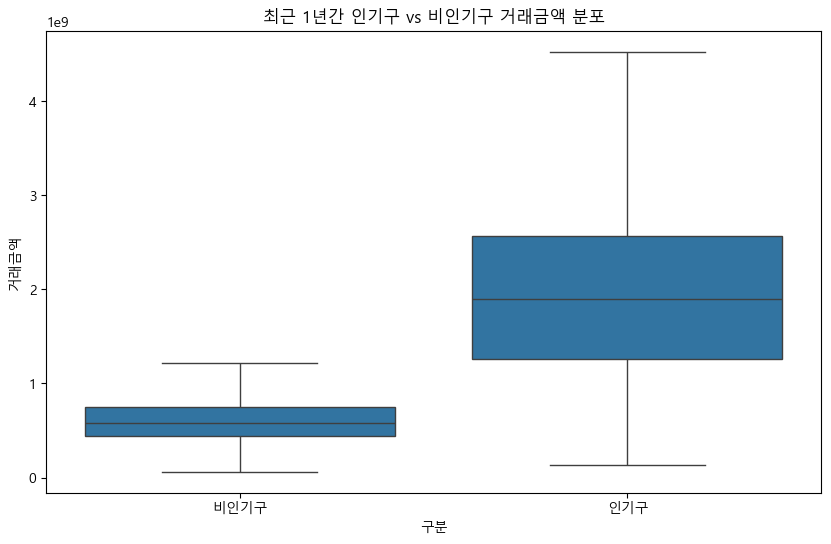

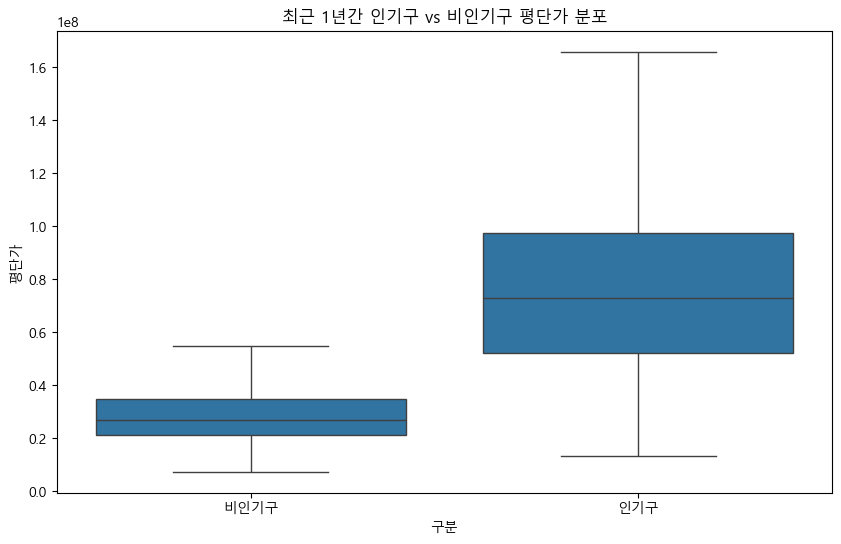

,거래금액 하위5%,거래금액 상위5%,거래금액 중앙값,거래금액 IQR,거래금액 평균,거래금액 표준편차
인기구,668805054.6,4.139283e+09,1.896950e+09,1.308143e+09,2.062844e+09,1.177954e+09
비인기구,217757375.0,1.591913e+09,5.766644e+08,3.153315e+08,6.623773e+08,3.969683e+08


In [14]:
# 최근 12개월 기준 필터링
latest_month = df_sales_copy['계약월'].max()
one_year_ago = latest_month - pd.DateOffset(months=12)
df_recent = df_sales_copy[df_sales_copy['계약월'] > one_year_ago]
df_plot = df_recent[df_recent['구분'].isin(['인기구','비인기구'])]

# 박스플롯: 거래금액
plt.figure(figsize=(10,6))
sns.boxplot(x='구분', y='거래금액', data=df_plot, showfliers=False)
plt.title('최근 1년간 인기구 vs 비인기구 거래금액 분포')
plt.ylabel('거래금액')
plt.show()

# 박스플롯: 평단가
plt.figure(figsize=(10,6))
sns.boxplot(x='구분', y='평단가', data=df_plot, showfliers=False)
plt.title('최근 1년간 인기구 vs 비인기구 평단가 분포')
plt.ylabel('평단가')
plt.show()

# 요약 통계: 중앙값, IQR, 상위/하위 5% 표시

summary_stats = {}
for group in ['인기구','비인기구']:
    subset = df_plot[df_plot['구분']==group]['거래금액']
    iqr = subset.quantile(0.75) - subset.quantile(0.25)
    summary_stats[group] = {
        '거래금액 하위5%': subset.quantile(0.05),
        '거래금액 상위5%': subset.quantile(0.95),
        '거래금액 중앙값': subset.median(),
        '거래금액 IQR': iqr,
        '거래금액 평균': subset.mean(),
        '거래금액 표준편차': subset.std()
    }

summary_stats_df = pd.DataFrame(summary_stats).T
display(summary_stats_df)


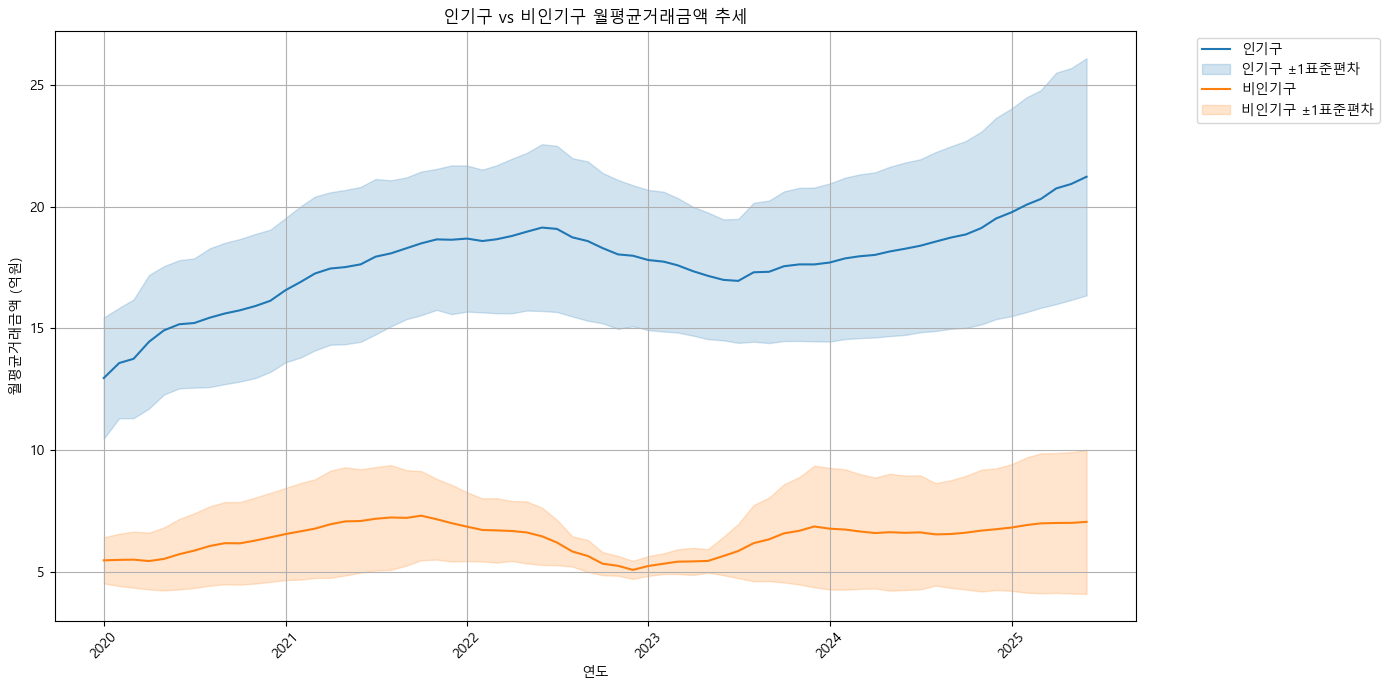

In [34]:
# 인기구/비인기구 데이터 선택
df_plot = monthly_stats[monthly_stats['구'].isin(popular + unpopular)].copy()
df_plot['구분'] = df_plot['구'].apply(lambda x: '인기구' if x in popular else '비인기구')

# 구분별 월평균과 표준편차 계산
df_summary = df_plot.groupby(['계약월','구분'])['이동평균'].agg(['mean','std']).reset_index()

# 색상 설정
colors = {'인기구':'tab:blue', '비인기구':'tab:orange'}

plt.figure(figsize=(14,7))

for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    plt.plot(subset['계약월'], subset['mean']/1e8, label=f'{group}', color=colors[group])
    plt.fill_between(subset['계약월'],
                     (subset['mean'] - subset['std'])/1e8,
                     (subset['mean'] + subset['std'])/1e8,
                     color=colors[group], alpha=0.2, label=f'{group} ±1표준편차')

plt.title('인기구 vs 비인기구 월평균거래금액 추세')
plt.xlabel('연도')
plt.ylabel('월평균거래금액 (억원)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


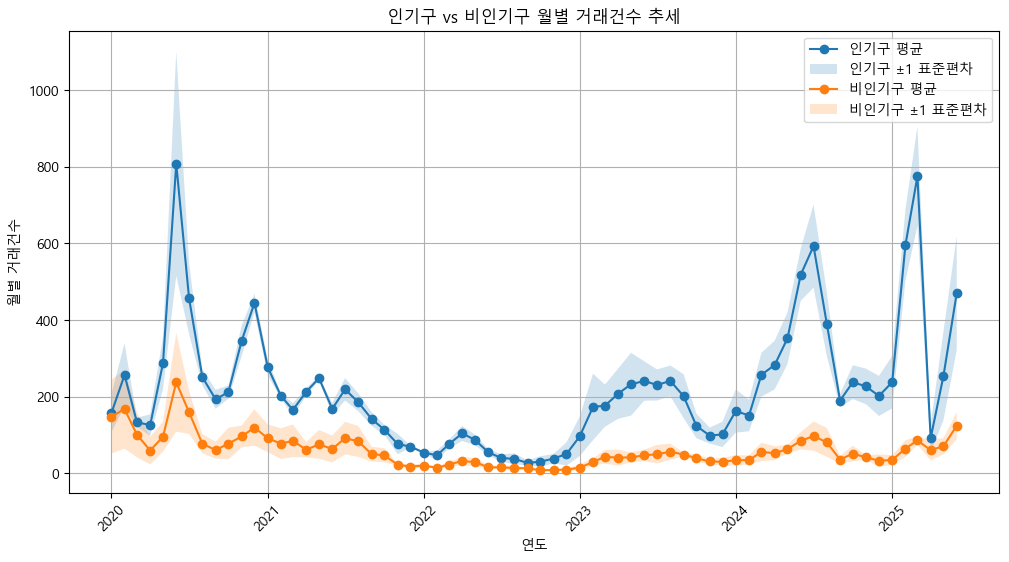

In [16]:
# 구분별 평균과 표준편차 계산
df_plot = monthly_stats[monthly_stats['구분'].isin(['인기구','비인기구'])]
df_summary = df_plot.groupby(['계약월','구분'])['월별거래건수'].agg(['mean','std']).reset_index()

plt.figure(figsize=(12,6))

for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    plt.plot(subset['계약월'], subset['mean'], marker='o', label=f'{group} 평균')
    plt.fill_between(subset['계약월'],
                     subset['mean'] - subset['std'],
                     subset['mean'] + subset['std'],
                     alpha=0.2, label=f'{group} ±1 표준편차')

plt.title('인기구 vs 비인기구 월별 거래건수 추세')
plt.xlabel('연도')
plt.ylabel('월별 거래건수')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

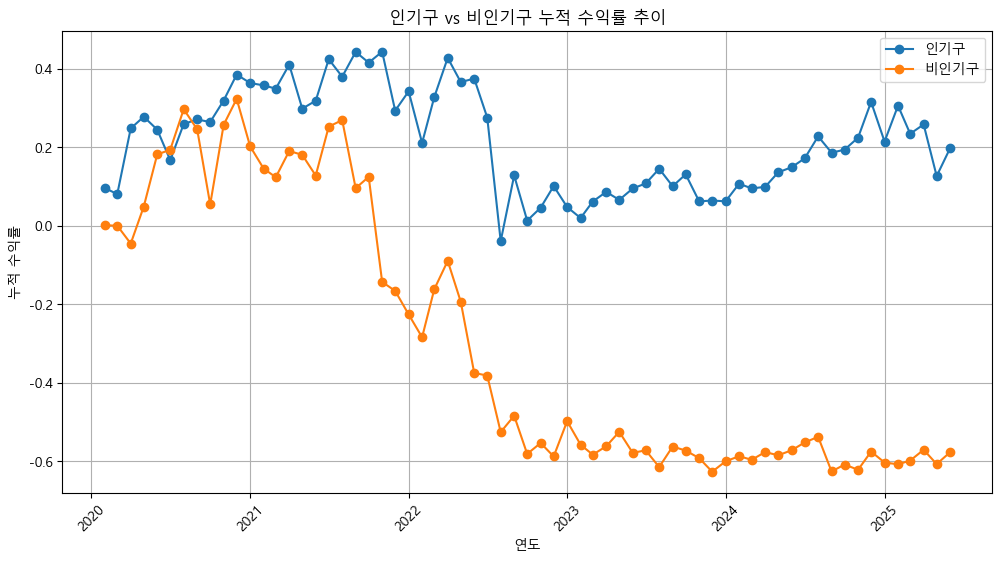

In [17]:

# 누적 수익률 계산
df_plot = monthly_stats[monthly_stats['구분'].isin(['인기구','비인기구'])]
df_plot = df_plot.sort_values(['구','계약월'])
df_plot['누적수익률'] = df_plot.groupby('구')['월별수익률'].transform(lambda x: (1 + x).cumprod() - 1)

# 구별 누적 수익률 평균 계산 (인기구/비인기구)
df_avg = df_plot.groupby(['계약월','구분'])['누적수익률'].mean().reset_index()

# 라인 차트
plt.figure(figsize=(12,6))
for group in ['인기구','비인기구']:
    subset = df_avg[df_avg['구분']==group]
    plt.plot(subset['계약월'], subset['누적수익률'], marker='o', label=group)

plt.title('인기구 vs 비인기구 누적 수익률 추이')
plt.xlabel('연도')
plt.ylabel('누적 수익률')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()
